In [151]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE 

from collections import Counter
from sklearn.datasets import make_classification
from interpret.blackbox import LimeTabular
from lime.lime_tabular import LimeTabularExplainer
import shap
import matplotlib.pyplot as plt


In [152]:
all_data = pd.read_csv(r'/Users/ihteshamshah/Desktop/Postdoc/Dataset/NKR_IKNL_breast_syntheticdata.csv')
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key_nkr            60000 non-null  object 
 1   key_eid            60000 non-null  object 
 2   leeft              60000 non-null  int64  
 3   gesl               60000 non-null  int64  
 4   incjr              60000 non-null  int64  
 5   vit_stat           60000 non-null  int64  
 6   vit_stat_int       60000 non-null  int64  
 7   tumsoort           60000 non-null  int64  
 8   diag_basis         60000 non-null  int64  
 9   topo               60000 non-null  object 
 10  topo_sublok        60000 non-null  object 
 11  later              58391 non-null  float64
 12  morf               60000 non-null  int64  
 13  gedrag             60000 non-null  int64  
 14  diffgrad           60000 non-null  int64  
 15  ct                 59096 non-null  object 
 16  cn                 591

In [153]:
DataSet= all_data[['leeft' ,'gesl', 'tumsoort', 'diag_basis', 'topo', 'topo_sublok', 'later', 'morf', 'ct', 'cn', 'cm', 'pt', 'pn', 'cstadium', 'er_stat', 'pr_stat', 'her2_stat', 'dcis_comp', 'multifoc','chemo', 'target', 'horm', 'rt', 'meta_chir', 'uitgebr_chir_code']]
DataSet.rename(columns={'chemo': 'chemo', 'target': 'target', 'horm': 'hormonal', 'rt': 'radio',  'meta_chir': 'surgery'}, inplace=True)
DataSet.dropna(inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [154]:
DataSet.reset_index(drop=True, inplace=True)
DataSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34242 entries, 0 to 34241
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   leeft              34242 non-null  int64  
 1   gesl               34242 non-null  int64  
 2   tumsoort           34242 non-null  int64  
 3   diag_basis         34242 non-null  int64  
 4   topo               34242 non-null  object 
 5   topo_sublok        34242 non-null  object 
 6   later              34242 non-null  float64
 7   morf               34242 non-null  int64  
 8   ct                 34242 non-null  object 
 9   cn                 34242 non-null  object 
 10  cm                 34242 non-null  float64
 11  pt                 34242 non-null  object 
 12  pn                 34242 non-null  object 
 13  cstadium           34242 non-null  object 
 14  er_stat            34242 non-null  float64
 15  pr_stat            34242 non-null  float64
 16  her2_stat          342

In [155]:
new_df = DataSet.iloc[[0,11,12,13,14]]

In [156]:
pd.set_option('display.max_columns', None)
new_df.replace({False: 0, True: 1}, inplace=True)
new_df.head()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,leeft,gesl,tumsoort,diag_basis,topo,topo_sublok,later,morf,ct,cn,cm,pt,pn,cstadium,er_stat,pr_stat,her2_stat,dcis_comp,multifoc,chemo,target,hormonal,radio,surgery,uitgebr_chir_code
0,38,2,501300,7,C50,C504,1.0,8481,1B,0,0.0,1C,0S,1A,1.0,1.0,1.0,1.0,0.0,0,0,0,2,0,131C50
11,71,2,501300,7,C50,C504,1.0,8520,1B,0,0.0,IS,0,1A,0.0,0.0,3.0,0.0,0.0,2,0,0,2,0,315000
12,48,2,501300,7,C50,C504,2.0,8500,1C,0,0.0,1C,0S,1A,1.0,1.0,3.0,0.0,0.0,1,0,2,2,0,131C50
13,77,2,501300,7,C50,C504,1.0,8500,1C,0,0.0,1C,0S,1A,0.0,0.0,2.0,1.0,0.0,0,1,0,2,0,131C50
14,83,2,501300,7,C50,C501,2.0,8500,1C,0,0.0,1B,0S,1A,1.0,0.0,7.0,1.0,0.0,0,0,2,0,0,141C50


In [157]:
data = pd.get_dummies(DataSet, drop_first = True) #drop_first= ture prevents from dummy trap and it delete the first column.
data.reset_index(drop=True, inplace=True)
DATA=data #for later use when dealing with imbalance dataset (weight and smote methods)
data.head()

,leeft,gesl,tumsoort,diag_basis,later,morf,cm,er_stat,pr_stat,her2_stat,dcis_comp,multifoc,chemo,target,hormonal,radio,surgery,topo_sublok_C501,topo_sublok_C502,topo_sublok_C503,topo_sublok_C504,topo_sublok_C505,topo_sublok_C506,topo_sublok_C508,topo_sublok_C509,ct_1,ct_1A,ct_1B,ct_1C,ct_1M,ct_2,ct_3,ct_4A,ct_4B,ct_4C,ct_4D,ct_IS,cn_1,cn_2A,cn_2B,cn_3A,cn_3B,cn_3C,pt_1,pt_1A,pt_1B,pt_1C,pt_1M,pt_2,pt_3,pt_4A,pt_4B,pt_4C,pt_4D,pt_IS,pn_0I,pn_0IS,pn_0S,pn_1A,pn_1AS,pn_1B,pn_1BS,pn_1C,pn_1CS,pn_1M,pn_1MS,pn_2A,pn_2AS,pn_2B,pn_3A,pn_3B,pn_3C,cstadium_1A,cstadium_2A,cstadium_2B,cstadium_3A,cstadium_3B,cstadium_3C,cstadium_4,cstadium_M,uitgebr_chir_code_132C50,uitgebr_chir_code_141C50,uitgebr_chir_code_142C50,uitgebr_chir_code_190000,uitgebr_chir_code_315000
0,38,2,501300,7,1.0,8481,0.0,1.0,1.0,1.0,1.0,0.0,0,0,0,2,0,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
1,29,2,501300,7,2.0,8500,0.0,1.0,1.0,1.0,1.0,0.0,0,0,2,2,0,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
2,82,2,501300,7,1.0,8500,0.0,1.0,1.0,0.0,1.0,0.0,2,2,2,0,0,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False
3,67,2,501300,7,2.0,8501,0.0,1.0,1.0,0.0,0.0,0.0,0,0,0,0,0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False
4,61,2,501300,7,1.0,8500,0.0,1.0,1.0,3.0,1.0,0.0,1,3,2,2,0,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False


In [158]:
new_df = data.iloc[[0, 13]]

In [159]:
new_df.replace({False: 0, True: 1}, inplace=True)
new_df.head()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,leeft,gesl,tumsoort,diag_basis,later,morf,cm,er_stat,pr_stat,her2_stat,dcis_comp,multifoc,chemo,target,hormonal,radio,surgery,topo_sublok_C501,topo_sublok_C502,topo_sublok_C503,topo_sublok_C504,topo_sublok_C505,topo_sublok_C506,topo_sublok_C508,topo_sublok_C509,ct_1,ct_1A,ct_1B,ct_1C,ct_1M,ct_2,ct_3,ct_4A,ct_4B,ct_4C,ct_4D,ct_IS,cn_1,cn_2A,cn_2B,cn_3A,cn_3B,cn_3C,pt_1,pt_1A,pt_1B,pt_1C,pt_1M,pt_2,pt_3,pt_4A,pt_4B,pt_4C,pt_4D,pt_IS,pn_0I,pn_0IS,pn_0S,pn_1A,pn_1AS,pn_1B,pn_1BS,pn_1C,pn_1CS,pn_1M,pn_1MS,pn_2A,pn_2AS,pn_2B,pn_3A,pn_3B,pn_3C,cstadium_1A,cstadium_2A,cstadium_2B,cstadium_3A,cstadium_3B,cstadium_3C,cstadium_4,cstadium_M,uitgebr_chir_code_132C50,uitgebr_chir_code_141C50,uitgebr_chir_code_142C50,uitgebr_chir_code_190000,uitgebr_chir_code_315000
0,38,2,501300,7,1.0,8481,0.0,1.0,1.0,1.0,1.0,0.0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
13,77,2,501300,7,1.0,8500,0.0,0.0,0.0,2.0,1.0,0.0,0,1,0,2,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [160]:
X = data.loc[:, ~data.columns.isin(['chemo','target','hormonal','radio','surgery'])]
Y = data[['chemo','target','hormonal','radio','surgery']]


In [161]:
test_X= new_df.loc[:, ~new_df.columns.isin(['chemo','target','hormonal','radio','surgery'])]
test_Y = new_df[['chemo','target','hormonal','radio','surgery']]


In [162]:
pd.set_option('display.max_columns', None)
test_X


,leeft,gesl,tumsoort,diag_basis,later,morf,cm,er_stat,pr_stat,her2_stat,dcis_comp,multifoc,topo_sublok_C501,topo_sublok_C502,topo_sublok_C503,topo_sublok_C504,topo_sublok_C505,topo_sublok_C506,topo_sublok_C508,topo_sublok_C509,ct_1,ct_1A,ct_1B,ct_1C,ct_1M,ct_2,ct_3,ct_4A,ct_4B,ct_4C,ct_4D,ct_IS,cn_1,cn_2A,cn_2B,cn_3A,cn_3B,cn_3C,pt_1,pt_1A,pt_1B,pt_1C,pt_1M,pt_2,pt_3,pt_4A,pt_4B,pt_4C,pt_4D,pt_IS,pn_0I,pn_0IS,pn_0S,pn_1A,pn_1AS,pn_1B,pn_1BS,pn_1C,pn_1CS,pn_1M,pn_1MS,pn_2A,pn_2AS,pn_2B,pn_3A,pn_3B,pn_3C,cstadium_1A,cstadium_2A,cstadium_2B,cstadium_3A,cstadium_3B,cstadium_3C,cstadium_4,cstadium_M,uitgebr_chir_code_132C50,uitgebr_chir_code_141C50,uitgebr_chir_code_142C50,uitgebr_chir_code_190000,uitgebr_chir_code_315000
0,38,2,501300,7,1.0,8481,0.0,1.0,1.0,1.0,1.0,0.0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
13,77,2,501300,7,1.0,8500,0.0,0.0,0.0,2.0,1.0,0.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [195]:
classes_names = {'chemo':['chemo_0','chemo_presurgical only','chemo_post-surgical only','chemo_pre and post surgical','chemo_Yes, no surgery'],
        'target':['target_0','target_presurgical only','target_post-surgical only','target_pre and post surgical','target_Yes, no surgery'],
        'hormonal':['hormonal_0','hormonal_presurgical only','hormonal_post-surgical only','hormonal_pre and post surgical','hormonal_Yes, no surgery'],
        'radio':['radio_0','radio_presurgical only','radio_post-surgical only','radio_Yes, no surgery'],
        'surgery':['No_surgery','surgery']}

#classes_names = {'chemo':['chemo_0','chemo_1','chemo_2','chemo_3','chemo_4'],
#        'target':['target_0','target_1','target_2','target_3','target_4'],
#        'hormonal':['hormonal_0','hormonal_1','hormonal_2','hormonal_3','hormonal_4'],
#        'radio':['radio_0','radio_1','radio_2','radio_4'],
#        'surgery':['surgery', 'No_surgery']}


y=Y['surgery']
smote = SMOTE(random_state=42)

X_class_resampled, y_class_resampled = smote.fit_resample(X , y)

X_class_resampled.replace({False: 0, True: 1}, inplace=True)
y_class_resampled.replace({False:0, True:1}, inplace= True)


print('Origianl dataset shape:', Counter(y))
print('Resampple dataset shape:', Counter(y_class_resampled))

x_train,x_test,y_train,y_test=train_test_split(X_class_resampled,y_class_resampled,test_size=0.02)

x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

#X_res, y_res = sm.fit_resample(x_train, y_train)

#Randomforest Classifier
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_pred = rf.predict(test_X)

Origianl dataset shape: Counter({0: 31621, 1: 2621})
Resampple dataset shape: Counter({0: 31621, 1: 31621})


In [196]:
test_Y


,chemo,target,hormonal,radio,surgery
0,0,0,0,2,0
13,0,1,0,2,0


In [197]:
# Choose a sample to explain
j = 1
sample = test_X.iloc[[j], :]

Predicted_class= rf.predict(sample)[0]
#print(f'Actual class: {test_Y[j]}')
print(f'Predicted class: {rf.predict(sample)[0]}')
print(f'Prediction for 1st sample in X_test: {rf.predict_proba(test_X.iloc[[j], :])[0]}')


Predicted class: 0
Prediction for 1st sample in X_test: [1. 0.]


In [198]:

sample.head()

,leeft,gesl,tumsoort,diag_basis,later,morf,cm,er_stat,pr_stat,her2_stat,dcis_comp,multifoc,topo_sublok_C501,topo_sublok_C502,topo_sublok_C503,topo_sublok_C504,topo_sublok_C505,topo_sublok_C506,topo_sublok_C508,topo_sublok_C509,ct_1,ct_1A,ct_1B,ct_1C,ct_1M,ct_2,ct_3,ct_4A,ct_4B,ct_4C,ct_4D,ct_IS,cn_1,cn_2A,cn_2B,cn_3A,cn_3B,cn_3C,pt_1,pt_1A,pt_1B,pt_1C,pt_1M,pt_2,pt_3,pt_4A,pt_4B,pt_4C,pt_4D,pt_IS,pn_0I,pn_0IS,pn_0S,pn_1A,pn_1AS,pn_1B,pn_1BS,pn_1C,pn_1CS,pn_1M,pn_1MS,pn_2A,pn_2AS,pn_2B,pn_3A,pn_3B,pn_3C,cstadium_1A,cstadium_2A,cstadium_2B,cstadium_3A,cstadium_3B,cstadium_3C,cstadium_4,cstadium_M,uitgebr_chir_code_132C50,uitgebr_chir_code_141C50,uitgebr_chir_code_142C50,uitgebr_chir_code_190000,uitgebr_chir_code_315000
13,77,2,501300,7,1.0,8500,0.0,0.0,0.0,2.0,1.0,0.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [199]:
#Shap Explainer single instance 

# Define the number of samples to summarize the background data
K = 100  # Choose an appropriate value for K

# Summarize the background data using shap.sample()
background_sample = shap.sample(x_train, K)

# Use the summarized background sample in your SHAP model
explainer = shap.KernelExplainer(model=rf.predict_proba, data=background_sample)

#shap_values = explainer.shap_values(x_test.iloc[[1], :], nsamples=100)
shap_values = explainer.shap_values(sample, nsamples=500)






  0%|          | 0/1 [00:00<?, ?it/s]

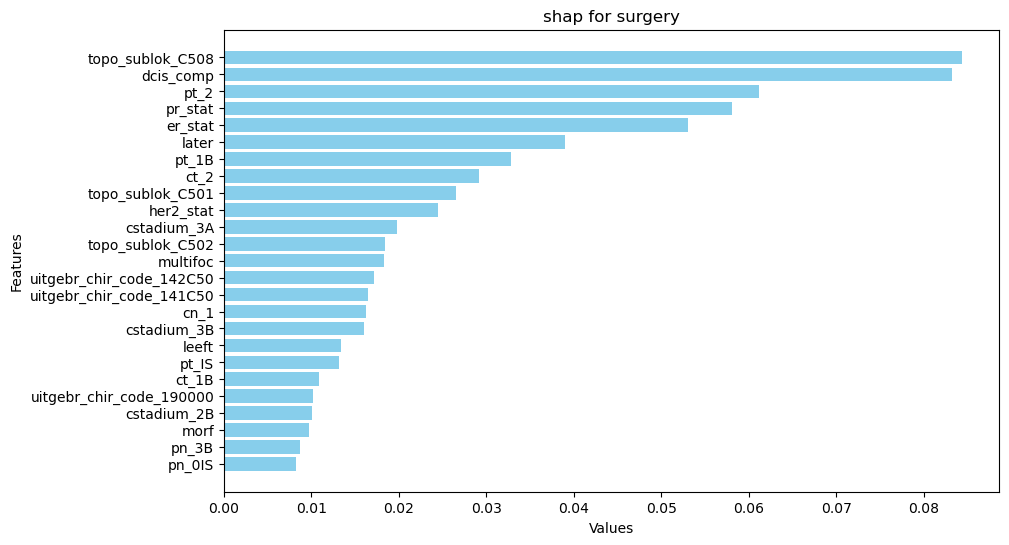

In [200]:
import numpy as np
import matplotlib.pyplot as plt

# Provided SHAP values and column names
shap_valuesss = shap_values[Predicted_class][0]
column_namesss = x_train.columns
# Flatten shap_values array
#shap_values = shap_values.flatten()

# Filter positive SHAP values
positive_shap_indices = np.where(shap_valuesss > 0)[0]
positive_shap_values = shap_valuesss[positive_shap_indices]
positive_shap_columns = np.array(column_namesss)[positive_shap_indices]

# Combine and sort by SHAP values
positive_shap_list = list(zip(positive_shap_columns, positive_shap_values))
positive_shap_list.sort(key=lambda x: x[1], reverse=True)

# Select top 20
top_10_shap = positive_shap_list[:25]

# Unzip to get column names and values
top_10_columns, top_10_values = zip(*top_10_shap)

# Plot the horizontal bar graph
plt.figure(figsize=(10, 6))
plt.barh(top_10_columns, top_10_values, color='skyblue')
plt.xlabel('Values')
plt.ylabel('Features')
plt.title('shap for surgery')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest value at the top
plt.show()


In [201]:
#LIME explainer single instance for same sample used for shap
# Choose a sample to explain



explainer = LimeTabularExplainer(x_train.values, 
                             feature_names=x_train.columns, 
                             class_names=classes_names[y_test.name], 
                             discretize_continuous=True)

sample =sample.values.reshape(1, -1) #reshape the sample and pickup the value only (making it suitble for lime function)
#print(f'Actual class: {y_test[j]}')
print(f'Predicted class: {rf.predict(sample)[0]}')

# Explain the prediction for the chosen sample
explanation = explainer.explain_instance(sample[0], rf.predict_proba, num_features=46, top_labels=30)

    

    

Predicted class: 0


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


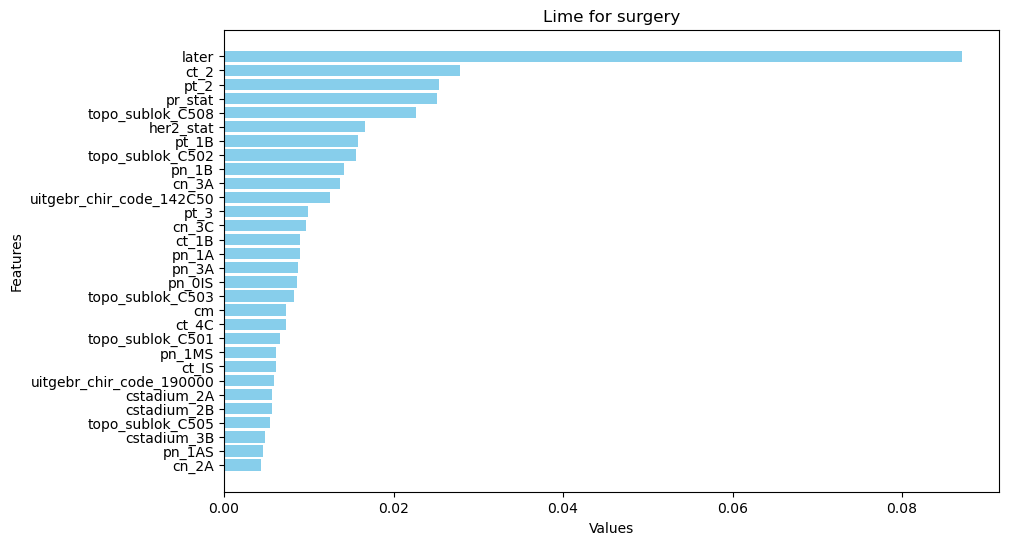

In [202]:
lime_values_of_Prid_cls= explanation.local_exp[Predicted_class]
positive_list = [(x, y) for x, y in lime_values_of_Prid_cls if y > 0]
# Separate the x and y values
column_names=column_namesss
x_values = [x for x, y in positive_list]
x_names = [column_names[t] for t in x_values]
y_values = [y for x, y in positive_list]

# Combine x_names and y_values into a list of tuples and sort by y_values
sorted_list = sorted(zip(x_names, y_values), key=lambda pair: pair[1])

# Unzip the sorted list
x_names_sorted, y_values_sorted = zip(*sorted_list)

# Create the horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(x_names_sorted, y_values_sorted, color='skyblue')
plt.xlabel('Values')
plt.ylabel('Features')
plt.title('Lime for surgery')
plt.show()

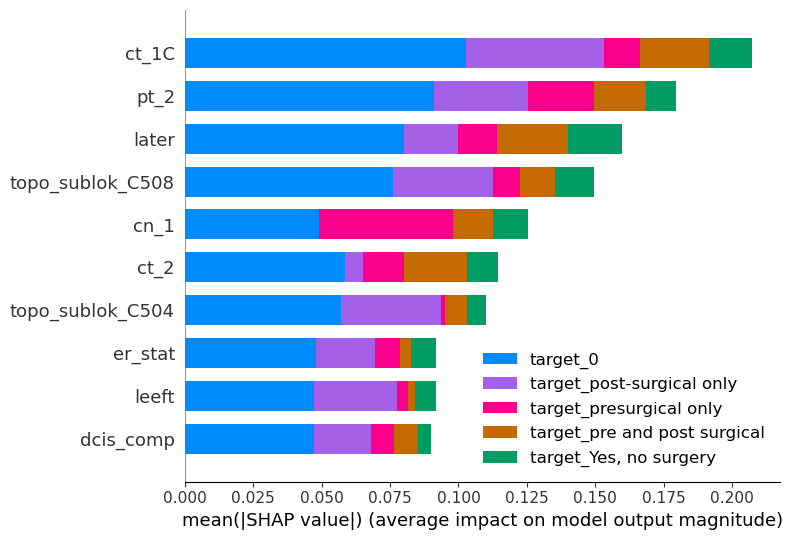

predicted_class= 0


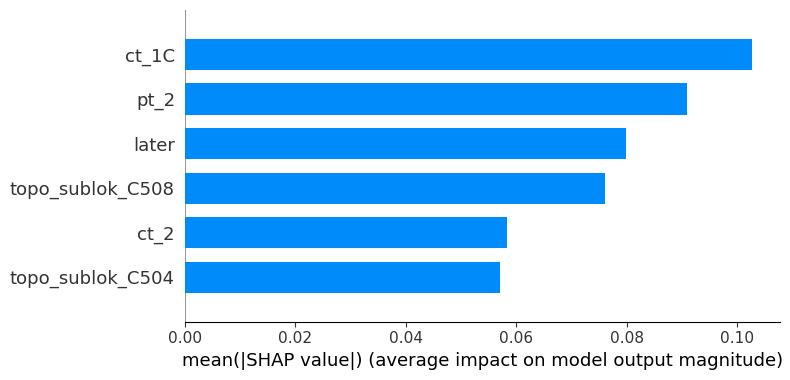

In [68]:
shap.summary_plot(shap_values, features=sample, feature_names=x_train.columns, class_names=classes_names[y_test.name], plot_type="bar",max_display=10, show=False)

plt.show()

# for single label explanation    shap.summary_plot(shap_values, features=sample, feature_names=X.columns, class_names=classes_names[y_test.name], plot_type="bar", show=False)

print('predicted_class=', Predicted_class)
shap.summary_plot(shap_values[Predicted_class], feature_names=x_train.columns, class_names=classes_names[y_test.name], plot_type="bar",max_display=6, show=False)

plt.show()

In [50]:
explanation.local_exp

{0: [(8, -0.08735777473671921),
  (10, -0.06527106046641418),
  (11, -0.060958525375513634),
  (7, -0.06073279955679794),
  (4, -0.05780360871454138),
  (15, 0.04334063799917614),
  (38, 0.02956065486410419),
  (33, -0.02848764603742568),
  (18, -0.026735142710537133),
  (25, -0.022460515243462313)],
 1: [(8, 0.08735777473671937),
  (10, 0.06527106046641408),
  (11, 0.06095852537551355),
  (7, 0.06073279955679786),
  (4, 0.057803608714541536),
  (15, -0.04334063799917613),
  (38, -0.029560654864104186),
  (33, 0.0284876460374257),
  (18, 0.026735142710537195),
  (25, 0.02246051524346238)]}

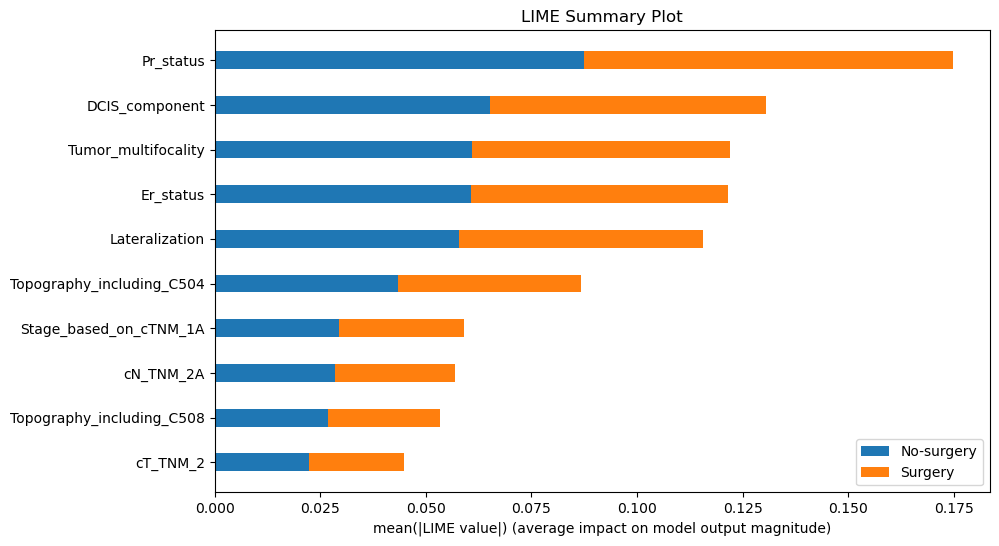

In [51]:
import matplotlib.pyplot as plt
import numpy as np

def plot_shap_summary(name, ad_dict, label_mapping, top_n_features=10):
    # Initialize the data storage
    feature_impact = {label: np.zeros(len(name)) for label in label_mapping.values()}

    # Process the ad_dict to extract feature impacts
    for label, impacts in ad_dict.items():
        for idx, value in impacts:
            feature_impact[label_mapping[label]][idx] = abs(value)

    # Combine the impact values for sorting
    combined_impact = np.zeros(len(name))
    for impacts in feature_impact.values():
        combined_impact += impacts

    # Get the indices of the top N features
    top_indices = np.argsort(combined_impact)[-top_n_features:][::-1]
    
    # Prepare the plot data for top features
    top_feature_impact = {label: impacts[top_indices] for label, impacts in feature_impact.items()}
    top_feature_names = np.array(name)[top_indices]

    # Prepare the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    y_pos = np.arange(top_n_features)
    bar_width = 0.4  # Adjust the bar width for visibility

    cumulative_values = np.zeros(top_n_features)

    # Plot data for each label
    for label, impacts in top_feature_impact.items():
        ax.barh(y_pos, impacts, bar_width, label=label, left=cumulative_values)
        cumulative_values += impacts

    # Add labels and legend
    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_feature_names)
    ax.invert_yaxis()  # Invert y axis to have the highest value on top
    ax.set_xlabel('mean(|LIME value|) (average impact on model output magnitude)')
    ax.set_title('LIME Summary Plot')
    ax.legend()

    plt.show()

# Usage
name = x_train.columns

ad_dict = explanation.local_exp

label_mapping = {0: 'No-surgery', 1: 'Surgery'}

# Specify the number of top features to display
top_n_features = 10
plot_shap_summary(name, ad_dict, label_mapping, top_n_features)


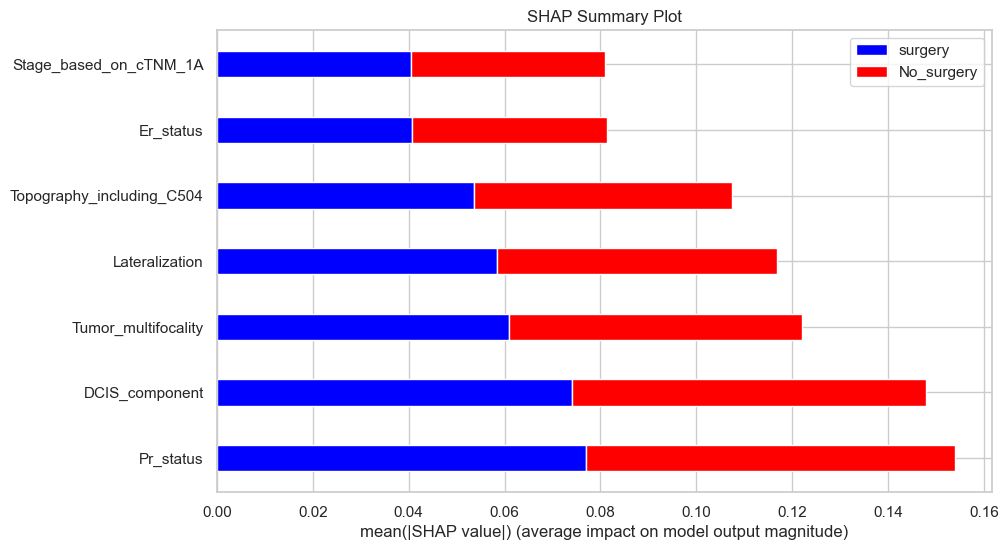

In [111]:
import matplotlib.pyplot as plt
import numpy as np

def plot_shap_summary(name, ad_dict, top_n_features=10):
    # Define the label mapping
    label_mapping = {0: 'surgery', 1: 'No_surgery'}
    
    # Initialize the data storage
    feature_impact = {label: np.zeros(len(name)) for label in label_mapping.values()}

    # Process the ad_dict to extract feature impacts
    for label, impacts in ad_dict.items():
        for idx, value in impacts:
            feature_impact[label_mapping[label]][idx] = abs(value)

    # Combine the impact values for sorting
    combined_impact = np.zeros(len(name))
    for impacts in feature_impact.values():
        combined_impact += impacts

    # Get the indices of the top N features
    top_indices = np.argsort(combined_impact)[-top_n_features:]
    
    # Prepare the plot data for top features
    top_feature_impact = {label: impacts[top_indices] for label, impacts in feature_impact.items()}
    top_feature_names = np.array(name)[top_indices]

    # Prepare the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    y_pos = np.arange(top_n_features)
    bar_width = 0.4  # Adjust the bar width for visibility

    # Plot data for 'surgery' first
    ax.barh(y_pos, top_feature_impact['surgery'], bar_width, label='surgery', color='blue')

    # Add data for 'No_surgery' on top of 'surgery'
    ax.barh(y_pos, top_feature_impact['No_surgery'], bar_width, label='No_surgery', color='red', left=top_feature_impact['surgery'])

    # Add labels and legend
    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_feature_names)
    ax.invert_yaxis()  # Invert y axis to have the highest value on top
    ax.set_xlabel('mean(|SHAP value|) (average impact on model output magnitude)')
    ax.set_title('SHAP Summary Plot')
    ax.legend()

    plt.show()

# Usage
name = x_train.columns

ad_dict = explanation.local_exp

# Specify the number of top features to display
top_n_features = 7
plot_shap_summary(name, ad_dict, top_n_features)



In [90]:
new

[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.05844732,
          0.        ,  0.        , -0.0407208 , -0.07700209,  0.02242849,
         -0.07401498,  0.0610125 ,  0.        ,  0.        ,  0.        ,
          0.05372608,  0.        ,  0.        , -0.0301659 ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         -0.02239568,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.04052593,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ]]),
 array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.05844732,
          0.        ,  0.        ,  0.0407208 ,  0.07700209, -0.02242849,
          0.07401498, -0.0610125 ,  0.        ,  0.        ,  0.        ,
         -0.05372608,  0.        ,  0.        ,  0.0301659 ,  0.        ,
          0. 

In [85]:
shap_values

[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.14925731,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         -0.17349722, -0.07927413, -0.00375198,  0.        ,  0.        ,
          0.        ,  0.        , -0.01310573, -0.03697897,  0.        ,
          0.        ,  0.        ,  0.        , -0.00483083,  0.        ,
         -0.06403701,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         -0.00772543,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ]]),
 array([[0.        , 0.        , 0.        , 0.        , 0.14925731,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.17349722, 0.07927413, 0.00375198, 0.        , 0.        ,
         0.        , 0.        , 0.01310573, 0.03697897, 0.        ,
         0.        , 0.        , 

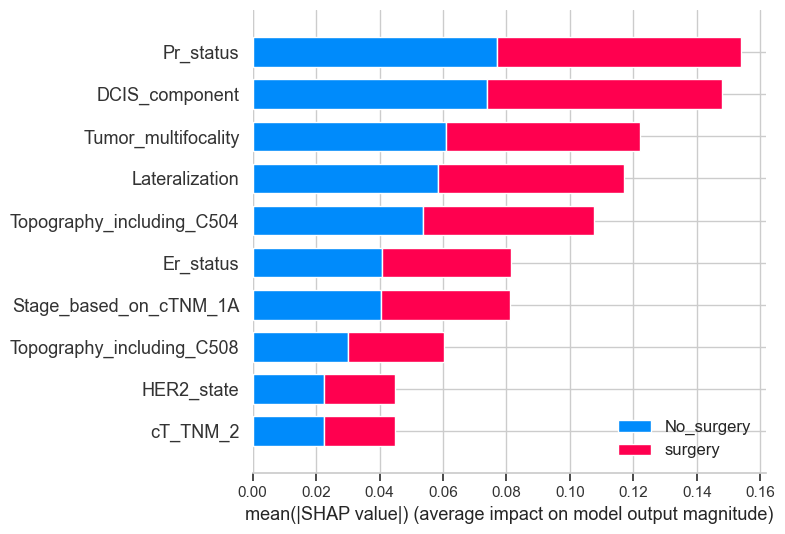

In [94]:
shap.summary_plot(new, features=sample, feature_names=X.columns, class_names=classes_names[y_test.name], plot_type="bar", max_display=10, show=False)

plt.show()


In [66]:
pd.DataFrame(explanation.as_list(),columns=['Feature','Contribution'])

,Feature,Contribution
0,0.00 < Pr_status <= 1.00,0.077002
1,0.14 < DCIS_component <= 1.00,0.074015
2,Tumor_multifocality > 0.00,-0.061013
3,1.55 < Lateralization <= 2.00,0.058447
4,Topography_including_C504 <= 0.00,-0.053726
5,Er_status <= 1.00,0.040721
6,Stage_based_on_cTNM_1A <= 0.00,-0.040526
7,0.00 < Topography_including_C508 <= 1.00,0.030166
8,HER2_state <= 0.00,-0.022428
9,0.00 < cT_TNM_2 <= 1.00,0.022396


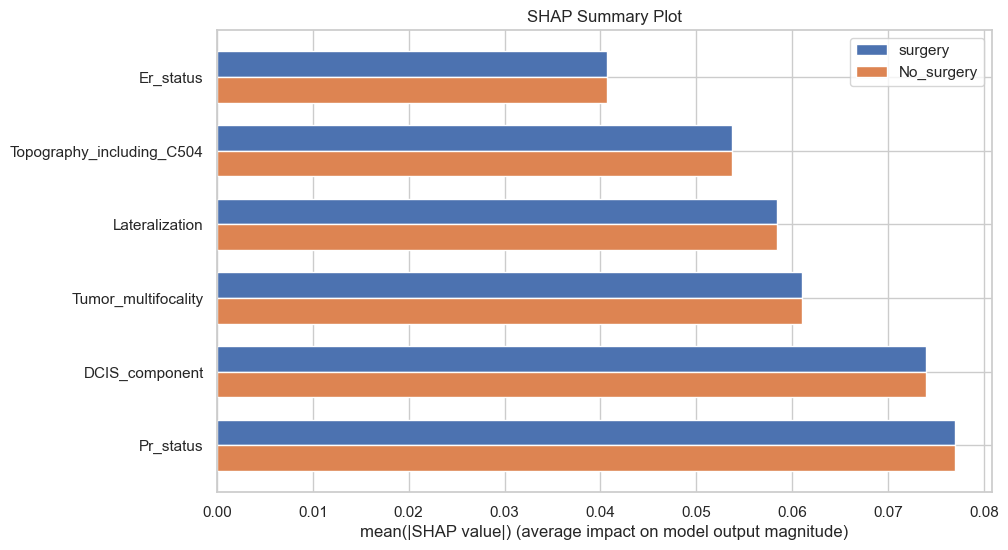

In [102]:
import matplotlib.pyplot as plt
import numpy as np

def plot_shap_summary(name, ad_dict, top_n_features=10):
    # Define the label mapping
    label_mapping = {0: 'surgery', 1: 'No_surgery'}
    
    # Initialize the data storage
    feature_impact = {label: np.zeros(len(name)) for label in label_mapping.values()}

    # Process the ad_dict to extract feature impacts
    for label, impacts in ad_dict.items():
        for idx, value in impacts:
            feature_impact[label_mapping[label]][idx] = abs(value)

    # Combine the impact values for sorting
    combined_impact = np.zeros(len(name))
    for impacts in feature_impact.values():
        combined_impact += impacts

    # Get the indices of the top N features
    top_indices = np.argsort(combined_impact)[-top_n_features:]
    
    # Prepare the plot data for top features
    top_feature_impact = {label: impacts[top_indices] for label, impacts in feature_impact.items()}
    top_feature_names = np.array(name)[top_indices]

    # Prepare the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    width = 0.35  # Width of the bars

    # Plot data for each label
    y_pos = np.arange(top_n_features)
    for i, (label, impacts) in enumerate(top_feature_impact.items()):
        ax.barh(y_pos + i * width, impacts, width, label=label)

    # Add labels and legend
    ax.set_yticks(y_pos + width / 2)
    ax.set_yticklabels(top_feature_names)
    ax.invert_yaxis()  # Invert y axis to have the highest value on top
    ax.set_xlabel('mean(|SHAP value|) (average impact on model output magnitude)')
    ax.set_title('SHAP Summary Plot')
    ax.legend()

    plt.show()

# Usage
name = ['Age_at_incidence_date', 'Sex', 'Tumor_type', 'Basis_for_diagnosis',
        'Lateralization', 'Morphology', 'cm_TNM', 'Er_status', 'Pr_status',
        'HER2_state', 'DCIS_component', 'Tumor_multifocality',
        'Topography_including_C501', 'Topography_including_C502',
        'Topography_including_C503', 'Topography_including_C504',
        'Topography_including_C505', 'Topography_including_C506',
        'Topography_including_C508', 'Topography_including_C509', 'cT_TNM_1',
        'cT_TNM_1A', 'cT_TNM_1B', 'cT_TNM_1C', 'cT_TNM_1M', 'cT_TNM_2',
        'cT_TNM_3', 'cT_TNM_4A', 'cT_TNM_4B', 'cT_TNM_4C', 'cT_TNM_4D',
        'cT_TNM_IS', 'cN_TNM_1', 'cN_TNM_2A', 'cN_TNM_2B', 'cN_TNM_3A',
        'cN_TNM_3B', 'cN_TNM_3C', 'Stage_based_on_cTNM_1A',
        'Stage_based_on_cTNM_2A', 'Stage_based_on_cTNM_2B',
        'Stage_based_on_cTNM_3A', 'Stage_based_on_cTNM_3B',
        'Stage_based_on_cTNM_3C', 'Stage_based_on_cTNM_4',
        'Stage_based_on_cTNM_M']

ad_dict = {
    0: [(8, -0.07700209032626924), (10, -0.07401498471352819), (11, 0.06101250125792561),
        (4, -0.05844731791714229), (15, 0.053726084383532415), (7, -0.04072079651622997),
        (38, 0.04052593344929543), (18, -0.030165901158114457), (9, 0.022428487844625325),
        (25, -0.02239567776375893)],
    1: [(8, 0.07700209032626924), (10, 0.0740149847135282), (11, -0.06101250125792568),
        (4, 0.0584473179171423), (15, -0.053726084383532484), (7, 0.040720796516229965),
        (38, -0.0405259334492954), (18, 0.030165901158114447), (9, -0.02242848784462526),
        (25, 0.02239567776375893)]
}

# Specify the number of top features to display
top_n_features = 6
plot_shap_summary(name, ad_dict, top_n_features)


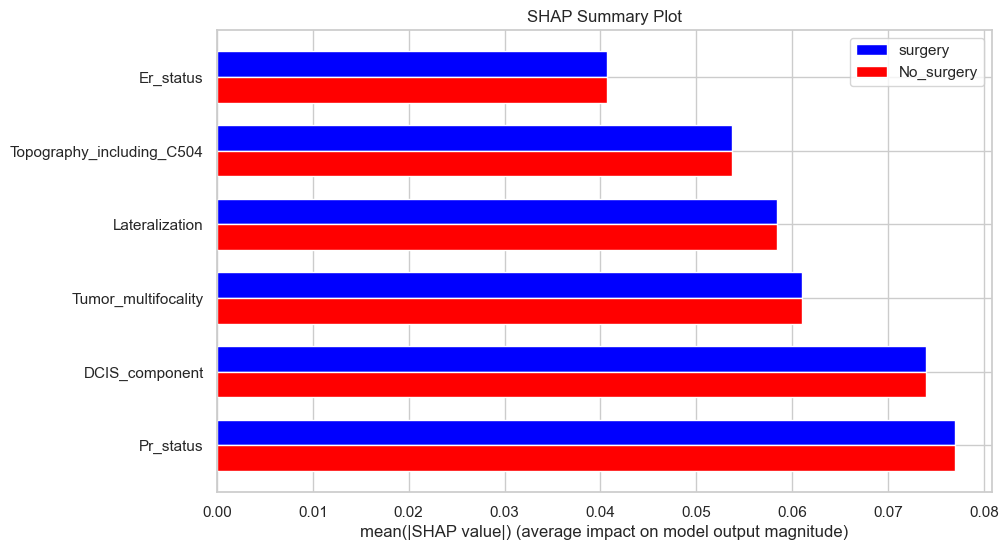

In [103]:
import matplotlib.pyplot as plt
import numpy as np

def plot_shap_summary(name, ad_dict, top_n_features=10):
    # Define the label mapping
    label_mapping = {0: 'surgery', 1: 'No_surgery'}
    
    # Initialize the data storage
    feature_impact = {label: np.zeros(len(name)) for label in label_mapping.values()}

    # Process the ad_dict to extract feature impacts
    for label, impacts in ad_dict.items():
        for idx, value in impacts:
            feature_impact[label_mapping[label]][idx] = abs(value)

    # Combine the impact values for sorting
    combined_impact = np.zeros(len(name))
    for impacts in feature_impact.values():
        combined_impact += impacts

    # Get the indices of the top N features
    top_indices = np.argsort(combined_impact)[-top_n_features:]
    
    # Prepare the plot data for top features
    top_feature_impact = {label: impacts[top_indices] for label, impacts in feature_impact.items()}
    top_feature_names = np.array(name)[top_indices]

    # Prepare the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    width = 0.35  # Width of the bars

    # Plot data for each label
    y_pos = np.arange(top_n_features)
    for i, (label, impacts) in enumerate(top_feature_impact.items()):
        if label == 'surgery':
            ax.barh(y_pos - width/2, impacts, width, label=label, color='blue')
        else:
            ax.barh(y_pos + width/2, impacts, width, label=label, color='red')

    # Add labels and legend
    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_feature_names)
    ax.invert_yaxis()  # Invert y axis to have the highest value on top
    ax.set_xlabel('mean(|SHAP value|) (average impact on model output magnitude)')
    ax.set_title('SHAP Summary Plot')
    ax.legend()

    plt.show()

# Usage
name = ['Age_at_incidence_date', 'Sex', 'Tumor_type', 'Basis_for_diagnosis',
        'Lateralization', 'Morphology', 'cm_TNM', 'Er_status', 'Pr_status',
        'HER2_state', 'DCIS_component', 'Tumor_multifocality',
        'Topography_including_C501', 'Topography_including_C502',
        'Topography_including_C503', 'Topography_including_C504',
        'Topography_including_C505', 'Topography_including_C506',
        'Topography_including_C508', 'Topography_including_C509', 'cT_TNM_1',
        'cT_TNM_1A', 'cT_TNM_1B', 'cT_TNM_1C', 'cT_TNM_1M', 'cT_TNM_2',
        'cT_TNM_3', 'cT_TNM_4A', 'cT_TNM_4B', 'cT_TNM_4C', 'cT_TNM_4D',
        'cT_TNM_IS', 'cN_TNM_1', 'cN_TNM_2A', 'cN_TNM_2B', 'cN_TNM_3A',
        'cN_TNM_3B', 'cN_TNM_3C', 'Stage_based_on_cTNM_1A',
        'Stage_based_on_cTNM_2A', 'Stage_based_on_cTNM_2B',
        'Stage_based_on_cTNM_3A', 'Stage_based_on_cTNM_3B',
        'Stage_based_on_cTNM_3C', 'Stage_based_on_cTNM_4',
        'Stage_based_on_cTNM_M']

ad_dict = {
    0: [(8, -0.07700209032626924), (10, -0.07401498471352819), (11, 0.06101250125792561),
        (4, -0.05844731791714229), (15, 0.053726084383532415), (7, -0.04072079651622997),
        (38, 0.04052593344929543), (18, -0.030165901158114457), (9, 0.022428487844625325),
        (25, -0.02239567776375893)],
    1: [(8, 0.07700209032626924), (10, 0.0740149847135282), (11, -0.06101250125792568),
        (4, 0.0584473179171423), (15, -0.053726084383532484), (7, 0.040720796516229965),
        (38, -0.0405259334492954), (18, 0.030165901158114447), (9, -0.02242848784462526),
        (25, 0.02239567776375893)]
}

# Specify the number of top features to display
top_n_features = 6
plot_shap_summary(name, ad_dict, top_n_features)


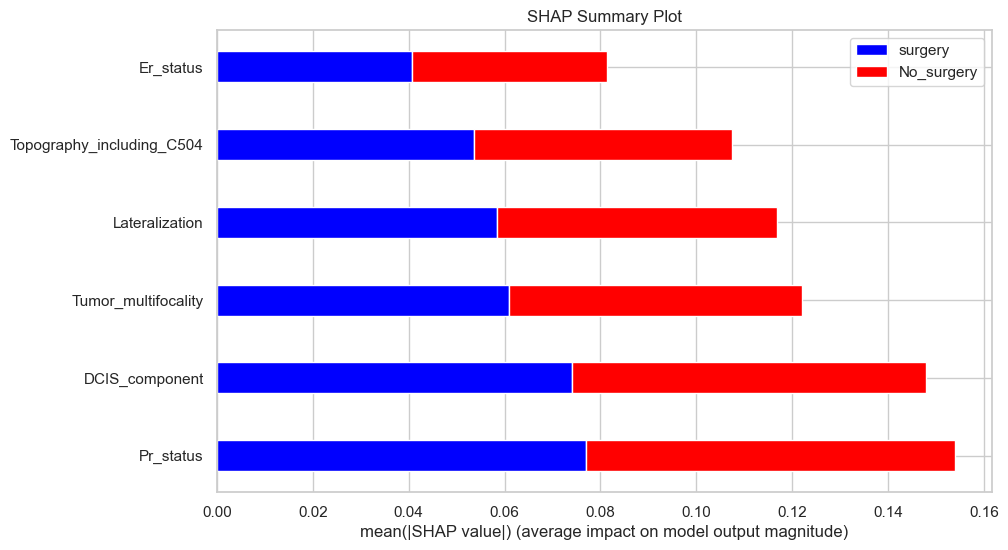

In [104]:
import matplotlib.pyplot as plt
import numpy as np

def plot_shap_summary(name, ad_dict, top_n_features=10):
    # Define the label mapping
    label_mapping = {0: 'surgery', 1: 'No_surgery'}
    
    # Initialize the data storage
    feature_impact = {label: np.zeros(len(name)) for label in label_mapping.values()}

    # Process the ad_dict to extract feature impacts
    for label, impacts in ad_dict.items():
        for idx, value in impacts:
            feature_impact[label_mapping[label]][idx] = abs(value)

    # Combine the impact values for sorting
    combined_impact = np.zeros(len(name))
    for impacts in feature_impact.values():
        combined_impact += impacts

    # Get the indices of the top N features
    top_indices = np.argsort(combined_impact)[-top_n_features:]
    
    # Prepare the plot data for top features
    top_feature_impact = {label: impacts[top_indices] for label, impacts in feature_impact.items()}
    top_feature_names = np.array(name)[top_indices]

    # Prepare the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    y_pos = np.arange(top_n_features)
    bar_width = 0.4  # Adjust the bar width for visibility

    # Plot data for 'surgery' first
    ax.barh(y_pos, top_feature_impact['surgery'], bar_width, label='surgery', color='blue')

    # Add data for 'No_surgery' on top of 'surgery'
    ax.barh(y_pos, top_feature_impact['No_surgery'], bar_width, label='No_surgery', color='red', left=top_feature_impact['surgery'])

    # Add labels and legend
    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_feature_names)
    ax.invert_yaxis()  # Invert y axis to have the highest value on top
    ax.set_xlabel('mean(|SHAP value|) (average impact on model output magnitude)')
    ax.set_title('SHAP Summary Plot')
    ax.legend()

    plt.show()

# Usage
name = ['Age_at_incidence_date', 'Sex', 'Tumor_type', 'Basis_for_diagnosis',
        'Lateralization', 'Morphology', 'cm_TNM', 'Er_status', 'Pr_status',
        'HER2_state', 'DCIS_component', 'Tumor_multifocality',
        'Topography_including_C501', 'Topography_including_C502',
        'Topography_including_C503', 'Topography_including_C504',
        'Topography_including_C505', 'Topography_including_C506',
        'Topography_including_C508', 'Topography_including_C509', 'cT_TNM_1',
        'cT_TNM_1A', 'cT_TNM_1B', 'cT_TNM_1C', 'cT_TNM_1M', 'cT_TNM_2',
        'cT_TNM_3', 'cT_TNM_4A', 'cT_TNM_4B', 'cT_TNM_4C', 'cT_TNM_4D',
        'cT_TNM_IS', 'cN_TNM_1', 'cN_TNM_2A', 'cN_TNM_2B', 'cN_TNM_3A',
        'cN_TNM_3B', 'cN_TNM_3C', 'Stage_based_on_cTNM_1A',
        'Stage_based_on_cTNM_2A', 'Stage_based_on_cTNM_2B',
        'Stage_based_on_cTNM_3A', 'Stage_based_on_cTNM_3B',
        'Stage_based_on_cTNM_3C', 'Stage_based_on_cTNM_4',
        'Stage_based_on_cTNM_M']

ad_dict = {
    0: [(8, -0.07700209032626924), (10, -0.07401498471352819), (11, 0.06101250125792561),
        (4, -0.05844731791714229), (15, 0.053726084383532415), (7, -0.04072079651622997),
        (38, 0.04052593344929543), (18, -0.030165901158114457), (9, 0.022428487844625325),
        (25, -0.02239567776375893)],
    1: [(8, 0.07700209032626924), (10, 0.0740149847135282), (11, -0.06101250125792568),
        (4, 0.0584473179171423), (15, -0.053726084383532484), (7, 0.040720796516229965),
        (38, -0.0405259334492954), (18, 0.030165901158114447), (9, -0.02242848784462526),
        (25, 0.02239567776375893)]
}

# Specify the number of top features to display
top_n_features = 6
plot_shap_summary(name, ad_dict, top_n_features)
